# Predicting NBA Statistics with Data Science

This data is from the 2020 NBA season, and we will be using the data to create a model to predict player's minutes played per game using their stats from the season.

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.options.display.float_format = '{:,.2f}'.format

# Loading Data



In [7]:
data = pd.read_csv('nba_2020_per_game.csv')

### Understanding the Variables

---------------------------

    Key Variables  
      1. MP       Minutes Played Per Game
      2. FG       Field Goals Made Per Game (A 2-pointer or 3-pointer)
      3. 3P       3-Pointers Made Per Game
      4. FG%/3P%  Field Goal % Made/3-Pointer % Made
      5. TRB      Rebounds Per Game
      6. AST      Assists Per Game
      7. STL      Steals Per Game
      8. BLK      Blocks Per Game
      9. PTS      Points Per Game

# Data Exploration

## Data Cleaning

In [8]:
data = data.drop_duplicates().fillna(0)

We will also remove data for those who have played less than 20 games (less than 25% of the season).

In [9]:
data = data[data.G > 25]
print(f"This data is conducted on {len(data.index)} NBA players during the 19-20 season.")

This data is conducted on 420 NBA players during the 19-20 season.


## Descriptive Statistics

In [10]:
data.describe()

Age      G     GS     MP     FG    FGA    FG%     3P    3PA    3P%  \
count 420.00 420.00 420.00 420.00 420.00 420.00 420.00 420.00 420.00 420.00   
mean   26.05  52.97  26.10  22.66   3.80   8.30   0.46   1.14   3.20   0.32   
std     4.05  13.26  24.58   7.64   2.16   4.56   0.07   0.87   2.22   0.10   
min    19.00  26.00   0.00   5.80   0.40   0.70   0.29   0.00   0.00   0.00   
25%    23.00  42.75   3.00  16.58   2.20   4.90   0.41   0.50   1.60   0.29   
50%    26.00  56.00  17.00  22.60   3.25   7.05   0.44   1.00   2.90   0.35   
75%    29.00  64.00  51.00  29.30   5.00  11.00   0.48   1.60   4.40   0.38   
max    43.00  74.00  73.00  37.50  10.90  22.90   0.78   4.40  12.40   1.00   

       ...    FT%    ORB    DRB    TRB    AST    STL    BLK    TOV     PF  \
count  ... 420.00 420.00 420.00 420.00 420.00 420.00 420.00 420.00 420.00   
mean   ...   0.75   0.96   3.27   4.23   2.25   0.72   0.47   1.30   1.97   
std    ...   0.11   0.77   1.83   2.45   1.80   0.38   0.43   0.81   0.68   
min    ...   0.35   0.10   0.50   0.60   0.20   0.10   0.00   0.10   0.50   
25%    ...   0.69   0.40   1.90   2.50   1.08   0.40   0.20   0.70   1.50   
50%    ...   0.78   0.70   2.90   3.75   1.60   0.70   0.30   1.10   1.90   
75%    ...   0.83   1.20   4.00   5.22   2.92   0.90   0.60   1.60   2.40   
max    ...   1.00   4.60  11.40  15.80  10.20   2.10   2.90   4.80   4.10   

         PTS  
count 420.00  
mean   10.38  
std     6.12  
min     1.30  
25%     5.80  
50%     8.80  
75%    13.55  
max    34.30  

[8 rows x 26 columns]

## Visualising the Data

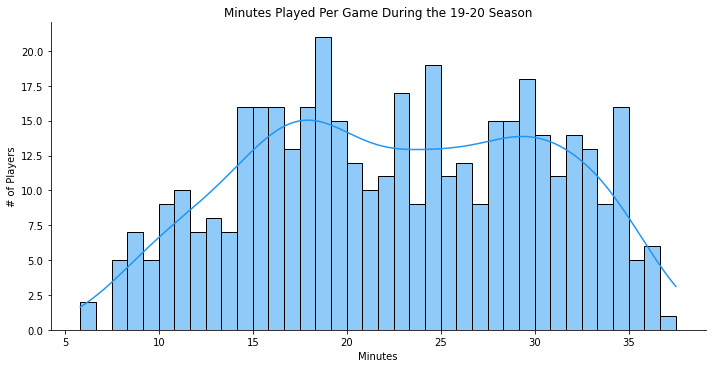

In [11]:
sns.displot(data["MP"], 
            bins=38, 
            aspect=2,
            kde=True, 
            color='#2196f3')

plt.title(f'Minutes Played Per Game During the 19-20 Season')
plt.xlabel('Minutes')
plt.ylabel('# of Players')
plt.show()

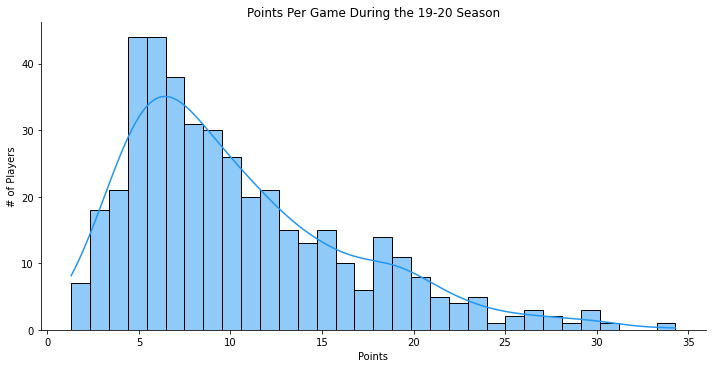

In [12]:
sns.displot(data["PTS"], 
            bins=32, 
            aspect=2,
            kde=True, 
            color='#2196f3')

plt.title(f'Points Per Game During the 19-20 Season')
plt.xlabel('Points')
plt.ylabel('# of Players')
plt.show()

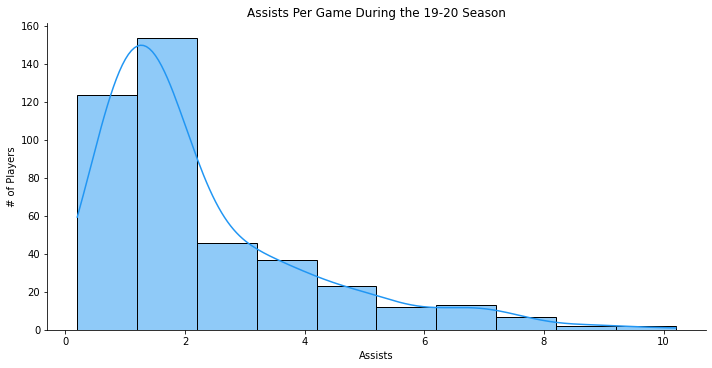

In [13]:
sns.displot(data["AST"], 
            bins=10,
            aspect=2,
            kde=True, 
            color='#2196f3')

plt.title(f'Assists Per Game During the 19-20 Season')
plt.xlabel('Assists')
plt.ylabel('# of Players')
plt.show()

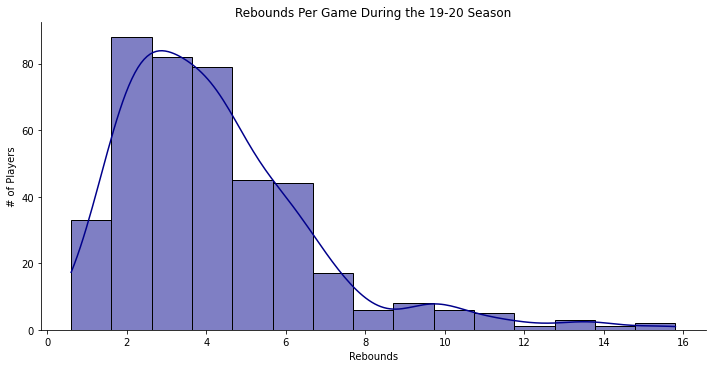

In [14]:
sns.displot(data["TRB"], 
            bins=15, 
            aspect=2,
            kde=True, 
            color='darkblue')

plt.title(f'Rebounds Per Game During the 19-20 Season')
plt.xlabel('Rebounds')
plt.ylabel('# of Players')
plt.show()

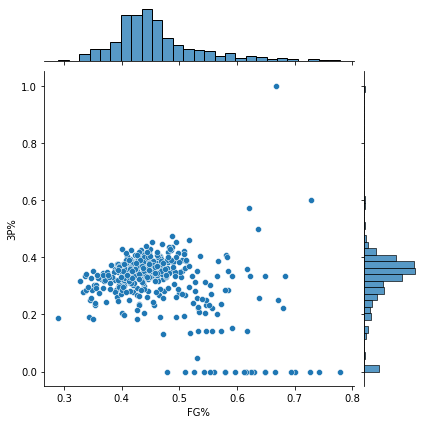

In [15]:
sns.jointplot(data=data, x="FG%", y="3P%")

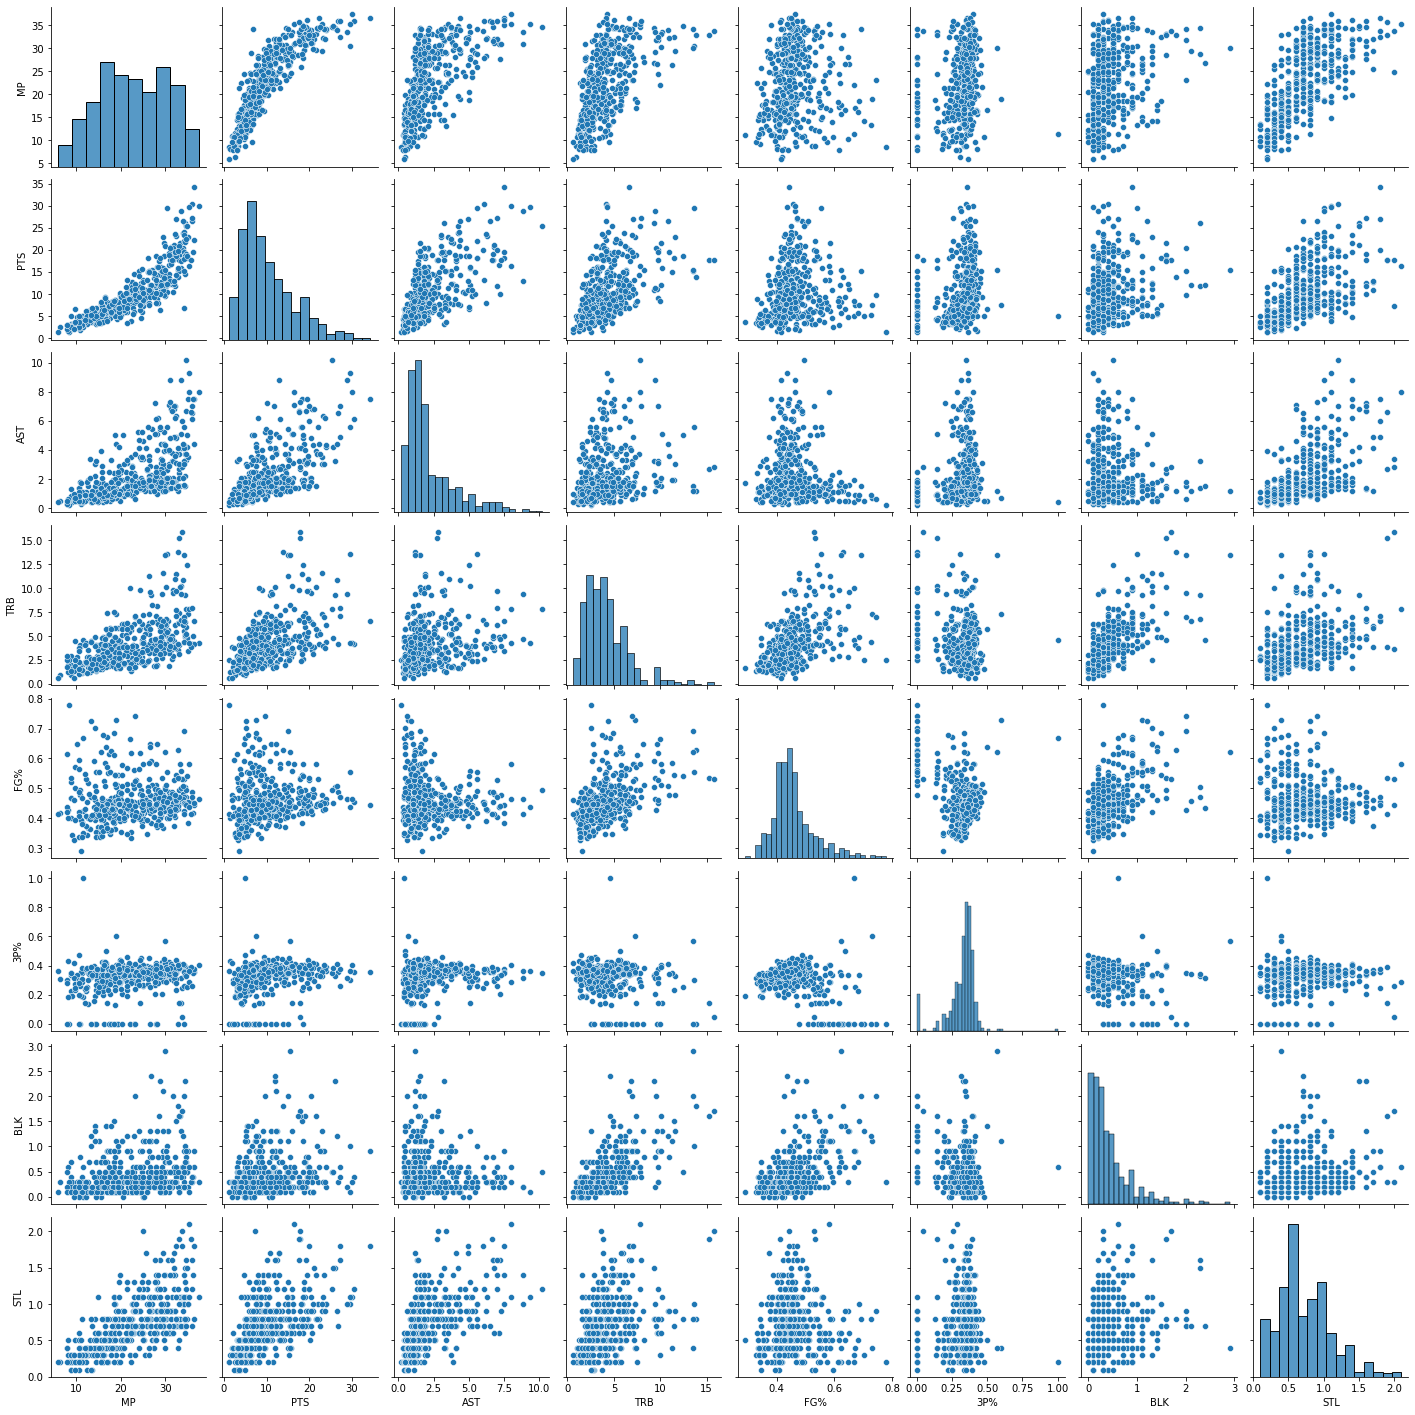

In [16]:
sns.pairplot(data[["MP", "PTS", "AST", "TRB", "FG%", "3P%", "BLK", "STL"]])

It appears that points, assists, and rebounds all have direct correlations with minutes played. Interestingly enough, while 3-point percentage appears to have a correlation with minutes played, field goal percentage does not. And while steals appears to have a correlation with minutes, blocks doesn't appear to have a correlation either. This is possibly because most players who get blocks are among the tallest on the team, while steals are gathered by everyone.

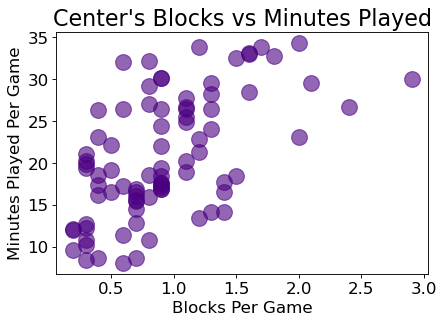

In [17]:
center_data = data[data.Pos == "C"]
plt.figure(dpi=80)
plt.scatter(x=center_data.BLK, y=center_data.MP, c='indigo', alpha=0.6, s=200)
plt.title("Center's Blocks vs Minutes Played", fontsize=20)
plt.xlabel('Blocks Per Game', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Minutes Played Per Game', fontsize=15)
plt.show()

Here we can see a much better correlation between blocks and minutes played.

Why might field goal percentage not have a strong correlation with minutes played? This may be have something to do with certain players' playstyles, such as taking longer range shots, or not being a good shooter but a great passer/rebounder.

# Split Training & Test Dataset

We are keeping 20% of the data for testing out-of-sample data. Due to the lack in correlation between blocks and FG% with minutes played, they will be excluded from the regression, as this regression is for all players of all positions.

In [18]:
target = data["MP"]
features = data[["PTS", "AST", "TRB", "3P%", "STL"]]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)
# % of training set
train_pct = 100*len(x_train)/len(features)
print(f'Training data is {train_pct:.3}% of the total data.')

# % of test data set
test_pct = 100*x_test.shape[0]/features.shape[0]
print(f'Test data makes up the remaining {test_pct:0.3}%.')

Training data is 80.0% of the total data.
Test data makes up the remaining 20.0%.


# Simple Linear Regression

In [19]:
reg = LinearRegression()
reg.fit(x_train, y_train)
rsquared = reg.score(x_train, y_train)
print(f'Training data r-squared: {rsquared:.2}')

Training data r-squared: 0.82


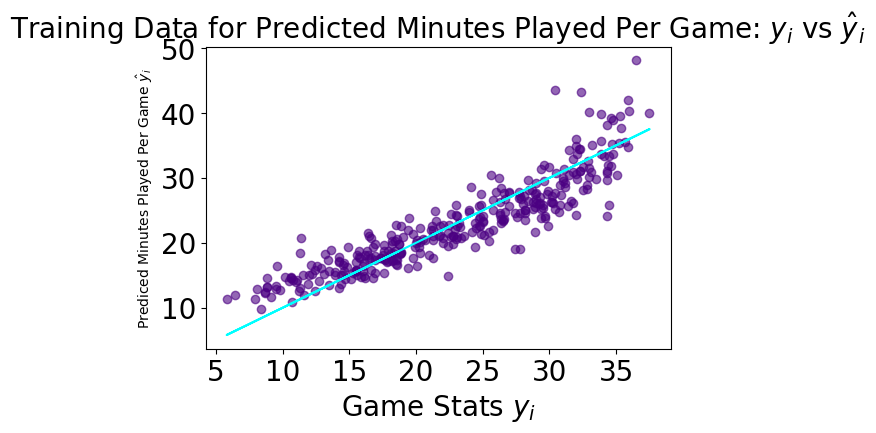

In [20]:
predicted_vals = reg.predict(x_train)
residuals = (y_train - predicted_vals)

# Original Regression of Actual vs. Predicted Prices
plt.figure(dpi=100)
plt.scatter(x=y_train, y=predicted_vals, c='indigo', alpha=0.6)
plt.plot(y_train, y_train, color='cyan')
plt.title(f'Training Data for Predicted Minutes Played Per Game: $y _i$ vs $\hat y_i$', fontsize=20)
plt.xlabel('Game Stats $y _i$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Prediced Minutes Played Per Game $\hat y _i$', fontsize=10)
plt.show()

### Evaluating the Coefficients

In [21]:
reg_coef = pd.DataFrame(data=reg.coef_, index=x_train.columns, columns=['Coefficient'])
reg_coef

Coefficient
PTS         0.70
AST         0.13
TRB         0.59
3P%         7.13
STL         5.89

It appears as steals has a massive impact on minutes per game, and that each point scored is more important than each assist or rebound in terms of playing time given.

### Analyse the Estimated Values & Regression Residuals

How good our regression is also depends on the residuals - the difference between the model's predictions ( ùë¶ÃÇ ùëñ ) and the true values ( ùë¶ùëñ ) inside y_train. Do you see any patterns in the distribution of the residuals?

In [22]:
predicted_vals = reg.predict(x_train)
residuals = (y_train - predicted_vals)

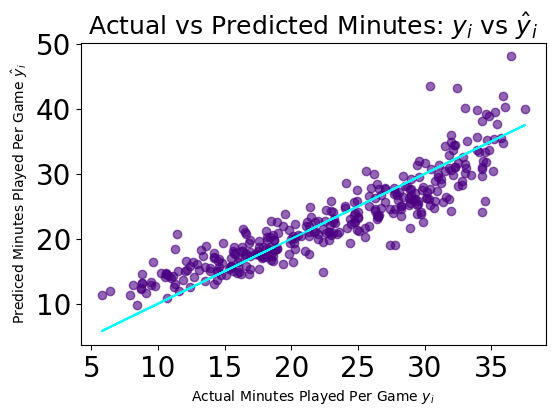

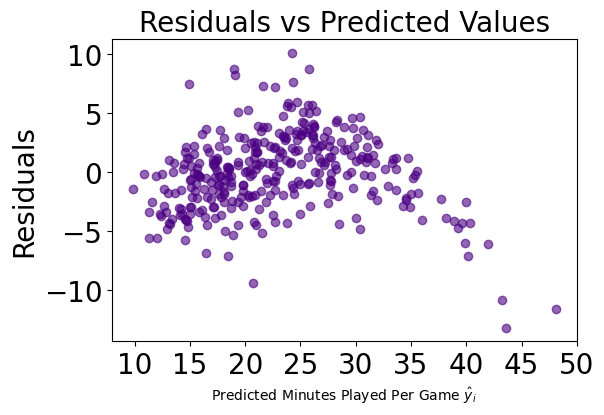

In [36]:
# Regression of Actual vs. Predicted Minutes
plt.figure(dpi=100)
plt.scatter(x=y_train, y=predicted_vals, c='indigo', alpha=0.6)
plt.plot(y_train, y_train, color='cyan')
plt.title(f'Actual vs Predicted Minutes: $y _i$ vs $\hat y_i$', fontsize=18)
plt.xlabel('Actual Minutes Played Per Game $y _i$', fontsize=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Prediced Minutes Played Per Game $\hat y _i$', fontsize=10)
plt.show()

# Residuals vs Predicted values
plt.figure(dpi=100)
plt.scatter(x=predicted_vals, y=residuals, c='indigo', alpha=0.6)
plt.title('Residuals vs Predicted Values', fontsize=20)
plt.xlabel('Predicted Minutes Played Per Game $\hat y _i$', fontsize=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Residuals', fontsize=20)
plt.show()

For values under 35 minutes per game, the residuals "bounce randomly" around the 0 line, suggesting that the assumption that the relationship is linear is reasonable. Since the residuals form a "horizontal band" around the 0 line, we can assume the variances of the error terms are equal.
Vaslues over 40 minutes stand out from the random pattern of the residuals, suggesting that those who play the most minutes per game are outliers, most likely due to their tremendous skill leading to them playing almost the whole game. 

# Using the Model to Make a Prediction

Entering players' stats, we will be able to see how accuarte the model is at predicting minutes played per game.

Jaylen Brown: 20.3 PTS, 2.1 AST, .382 3P%, 6.4 TRB, 0.4 STL

In [40]:
# Starting Point: Average Values in the Dataset
features = data[["PTS", "AST", "TRB", "3P%", "STL"]]
average_vals = np.array([20.3, 2.1, 6.4, .382, 0.4])
stats = pd.DataFrame(data=average_vals.reshape(1, len(features.columns)), 
                              columns=features.columns)
stats

PTS  AST  TRB  3P%  STL
0 20.30 2.10 6.40 0.38 0.40

In [42]:
estimate = reg.predict(stats)[0]
print(f'The regression predicts {estimate:.3} minutes per game for Jaylen Brown, who played 33.9 minutes per game.')

The regression predicts 29.5 minutes per game for Jaylen Brown, who played 33.9 minutes per game.


Matisse Thybulle: 4.7 PTS, 1.2 AST, .357 3P%, 1.6 TRB, 1.4 STL

In [43]:
# Starting Point: Average Values in the Dataset
features = data[["PTS", "AST", "TRB", "3P%", "STL"]]
average_vals = np.array([4.7, 1.2, 1.6, .357, 1.4])
stats = pd.DataFrame(data=average_vals.reshape(1, len(features.columns)), 
                              columns=features.columns)
stats

PTS  AST  TRB  3P%  STL
0 4.70 1.20 1.60 0.36 1.40

In [45]:
estimate = reg.predict(stats)[0]
print(f'The regression predicts {estimate:.3} minutes per game for Matisse Thybulle, who played 19.8 minutes per game.')

The regression predicts 21.4 minutes per game for Matisse Thybulle, who played 19.8 minutes per game.


Aaron Holiday: 9.5 PTS, 3.4 AST, .394 3P%, 2.4 TRB, 0.8 STL

In [46]:
# Starting Point: Average Values in the Dataset
features = data[["PTS", "AST", "TRB", "3P%", "STL"]]
average_vals = np.array([9.5, 3.4, 2.4, .394, 0.8])
stats = pd.DataFrame(data=average_vals.reshape(1, len(features.columns)), 
                              columns=features.columns)
stats

PTS  AST  TRB  3P%  STL
0 9.50 3.40 2.40 0.39 0.80

In [47]:
estimate = reg.predict(stats)[0]
print(f'The regression predicts {estimate:.3} minutes per game for Aaron Holiday, who played 24.5 minutes per game.')

The regression predicts 22.2 minutes per game for Aaron Holiday, who played 24.5 minutes per game.


Robert Williams: 5.2 PTS, 0.9 AST, .000 3P%, 4.4 TRB, 0.8 STL

In [48]:
# Starting Point: Average Values in the Dataset
features = data[["PTS", "AST", "TRB", "3P%", "STL"]]
average_vals = np.array([5.2, 0.9, 4.4, .0, 0.8])
stats = pd.DataFrame(data=average_vals.reshape(1, len(features.columns)), 
                              columns=features.columns)
stats

PTS  AST  TRB  3P%  STL
0 5.20 0.90 4.40 0.00 0.80

In [49]:
estimate = reg.predict(stats)[0]
print(f'The regression predicts {estimate:.3} minutes per game for Robert Williams, who played 13.2 minutes per game.')

The regression predicts 17.3 minutes per game for Robert Williams, who played 13.2 minutes per game.


# Conclusion

Overall, the linear model was fairly accurate, with the average error from the actual minutes played being just 2-3 minutes. There definitely could've been more statistics entered, such as turnovers, free throw percentage, and fouls. Also, to make the model more accurate, there could have been seperate models for each position, as point guards, who gather more assists and steals, play a whole different game than centers, who rack up more rebounds and blocks.

Something to consider is, do the minutes affect the statistics more than the statistics affect the minutes played? A player who doesn't play enough may not have enough chances to prove themselves to play more minutes. There also could be other good players in the same position on the same team, meaning less minutes for that player.